# Resources

In [1]:
# Install the torchmetrics package for storing loss, evaluation metrics, etc.
!pip install lightning-utilities
!pip install torchmetrics --no-deps
!pip install -q opendatasets # Install a package to download data from Kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 13.2 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
from torchvision.transforms.functional import to_pil_image
from torchmetrics import MeanMetric, Accuracy
from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, F1Score
import opendatasets as od

In [3]:
# Make sure to change runtime to GPU
# Check if GPU is avaiable
device = "cuda" if torch.cuda.is_available() \
          else "mps" if torch.mps.is_available() \
          else "cpu"
print("Device:", device)

Device: cpu


# Data

In [4]:
od.download('https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset', force = True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: afeezbisiriyu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset


100%|██████████| 534M/534M [00:01<00:00, 301MB/s]


Data Augmentaion for training samples

In [5]:
# data augmentation for train
train_transform = v2.Compose([
  v2.ColorJitter(brightness=0.3, contrast=0.5, saturation=0.5), # Adjust color
  v2.RandomHorizontalFlip(p=0.5), # Random horizontal flip
  v2.RandomResizedCrop(size=224, scale=(0.5, 1.0)), # Random crop and resize
  v2.ToImage(), # PyTorch Image format
  v2.ToDtype(torch.float32, scale=True), # Convert to tensor
  v2.Normalize(mean=[0.485, 0.456, 0.406],
               std=[0.229, 0.224, 0.225]), # Normalize
])

In [6]:
# data augmentation for validation and test
eval_transform = v2.Compose([
  v2.Resize((224, 224)), # resize image to 224
  v2.ToImage(), # PyTorch Image format
  v2.ToDtype(torch.float32, scale=True), # Convert to tensor
  v2.Normalize(mean=[0.485, 0.456, 0.406],
               std=[0.229, 0.224, 0.225]), # Normalize
])

In [7]:
# Read datasets
train_data = torchvision.datasets.ImageFolder("vegetable-image-dataset/Vegetable Images/train", transform=train_transform)
val_data = torchvision.datasets.ImageFolder("vegetable-image-dataset/Vegetable Images/test", transform=eval_transform) # Use eval_transform for test data
test_set = torchvision.datasets.ImageFolder("vegetable-image-dataset/Vegetable Images/validation", transform=eval_transform) # Use eval_transform for validation data

Data split and mini-batch data loading

In [8]:
# Split the original train data into training (80%) and validation (20%)
# Random split (only splitting indices, datasets are independent)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_indices, val_indices = torch.utils.data.random_split(range(len(train_data)),
                                                          [train_size, val_size])
# train_data and val_data have different transforms
train_set = torch.utils.data.Subset(train_data, train_indices)
val_set = torch.utils.data.Subset(train_data, val_indices)

print(f'Original train set has {len(train_data)} samples')
print(f'Validation set has {len(val_data)} samples')
print(f'Test set has {len(test_set)} samples')

Original train set has 15000 samples
Validation set has 3000 samples
Test set has 3000 samples


In [9]:
# Define the data loaders for the training, validation, and test sets
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [11]:
# Define the classes
classes = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum','Carrot','Cauliflower','Cucumber','Papaya','Potato','Pumpkin','Radish','Tomato']
num_classes = len(classes)
print("Number of classes:", num_classes)

Number of classes: 15


Number of samples per class:

In [12]:
def count_class_sample_number(dataset, classes):
  # Get the labels of all the data in the training set
  labels = [dataset[i][1] for i in range(len(dataset))]
  # Count the number of data per class
  class_counts = np.bincount(labels)
  # Print the number of samples per class
  for class_label, count in enumerate(class_counts):
    print("Class", classes[class_label], "has", count, "samples.")

print("Train:")
count_class_sample_number(train_set, classes)
print("Validation:")
count_class_sample_number(val_set, classes)
print("Test:")
count_class_sample_number(test_set, classes)

Train:
Class Bean has 813 samples.
Class Bitter_Gourd has 803 samples.
Class Bottle_Gourd has 810 samples.
Class Brinjal has 796 samples.
Class Broccoli has 818 samples.
Class Cabbage has 796 samples.
Class Capsicum has 813 samples.
Class Carrot has 794 samples.
Class Cauliflower has 795 samples.
Class Cucumber has 798 samples.
Class Papaya has 810 samples.
Class Potato has 772 samples.
Class Pumpkin has 793 samples.
Class Radish has 786 samples.
Class Tomato has 803 samples.
Validation:
Class Bean has 187 samples.
Class Bitter_Gourd has 197 samples.
Class Bottle_Gourd has 190 samples.
Class Brinjal has 204 samples.
Class Broccoli has 182 samples.
Class Cabbage has 204 samples.
Class Capsicum has 187 samples.
Class Carrot has 206 samples.
Class Cauliflower has 205 samples.
Class Cucumber has 202 samples.
Class Papaya has 190 samples.
Class Potato has 228 samples.
Class Pumpkin has 207 samples.
Class Radish has 214 samples.
Class Tomato has 197 samples.
Test:
Class Bean has 200 samples.

In [21]:
from collections import defaultdict

# Initialize dictionaries to store the count of images per class for train and test datasets
train_class_counts = defaultdict(int)
test_class_counts = defaultdict(int)

# Iterate through train dataset to count images per class
for _, label in train_data:
    train_class_counts[label] += 1

# Iterate through test dataset to count images per class
for _, label in test_set:
    test_class_counts[label] += 1

# Define a function to plot pie chart
def plot_pie_chart(class_counts, title):
    # Get class labels and corresponding counts
    labels = list(class_counts.keys())
    counts = list(class_counts.values())

    # Plot the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

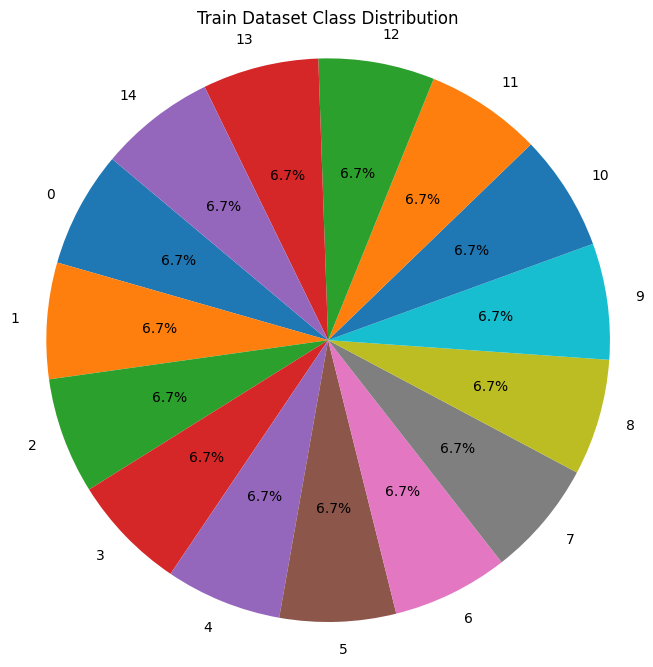

In [22]:
# Plot pie chart for train dataset
plot_pie_chart(train_class_counts, "Train Dataset Class Distribution")

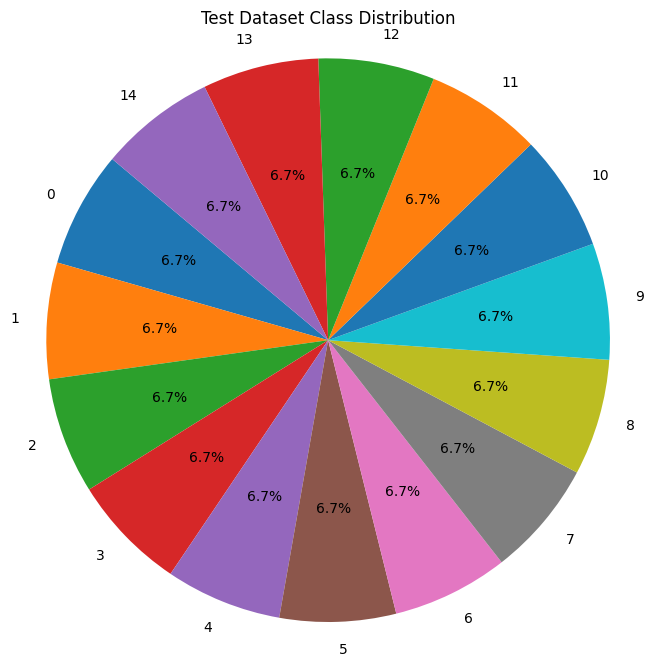

In [23]:
# Plot pie chart for test dataset
plot_pie_chart(test_class_counts, "Test Dataset Class Distribution")

Visualise image samples:

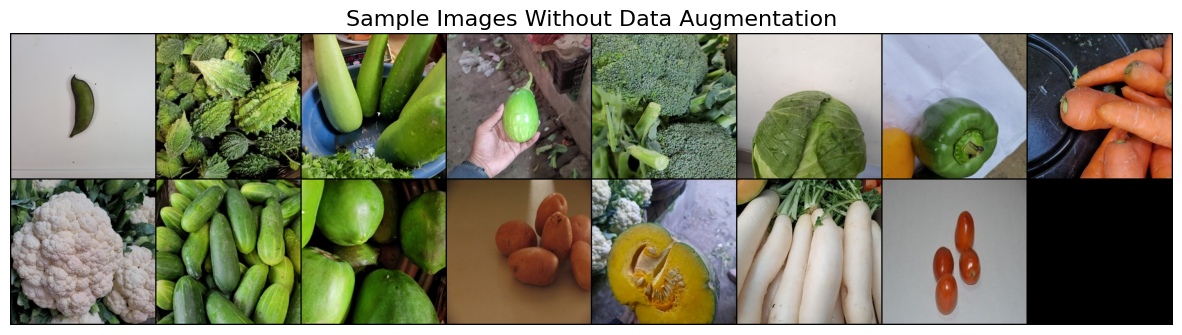

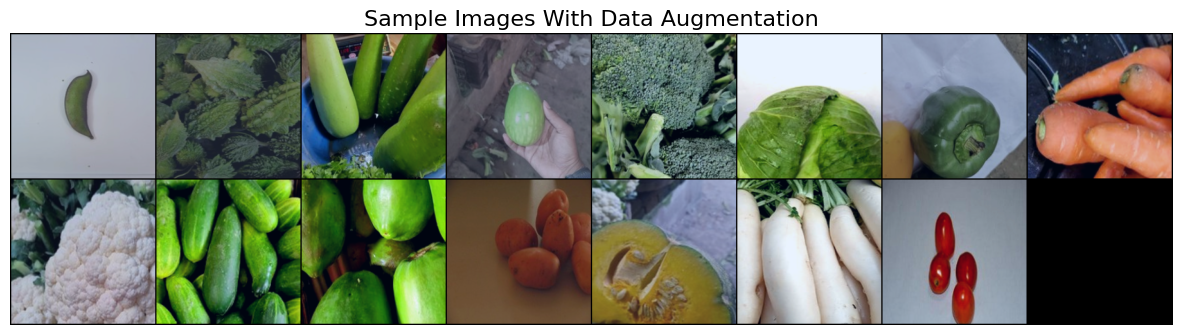

In [12]:

# Denormalization function
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    return tensor * std + mean

# Function to get one image per class and stack into a batch tensor
def get_sample_batch(dataset, classes, transform=None):
    images = []
    for class_i in range(len(classes)):
        for image_path, label in dataset.imgs:
            if label == class_i:
                image = Image.open(image_path).convert("RGB")
                if transform:
                    image = transform(image)
                else:
                    image = torchvision.transforms.ToTensor()(image)
                images.append(image)
                break
    batch = torch.stack(images)
    return batch

# Get sample batch without augmentation
sample_batch_no_aug = get_sample_batch(train_data, classes)

# Get sample batch with augmentation
sample_batch_aug = get_sample_batch(train_data, classes, transform=train_transform)

# Function to display grid image from a batch
def show_grid_image(batch_tensor, title, nrow=8):
    grid_img = torchvision.utils.make_grid(batch_tensor, nrow=nrow, padding=2, normalize=True)
    plt.figure(figsize=(15, 5))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Display images without augmentation
show_grid_image(sample_batch_no_aug, 'Sample Images Without Data Augmentation', nrow=8)

# Display images with augmentation
show_grid_image(sample_batch_aug, 'Sample Images With Data Augmentation', nrow=8)


# Model1

In [13]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 224, 224]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1), # set a convolution layer with out_channels=256, kernel_size=3, stride=1, padding=1
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0), # set a max pooling layer with kernel_size=4, stride=4, padding=0
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256*14*14, 256), # fill in the correct input feature size after flatten. The tensor shape before flatten is (256, 14, 14)
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 15)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, 15]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [14]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
# Initialize a model, and put it on the device specified.
model1 = MyCNN()
model1 = model1.to(device)

Loss and Optimizer

In [17]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model1.parameters(), lr=0.0001)

## Experiment

Training for one epoch:

In [18]:
# a function for training one epoch
# Updated function definition to accept criterion, optimizer, device, and num_classes
def train_one_epoch(model, dataloader, criterion, optimizer, device, num_classes):
  # Prepare for storing loss and accuracy
  losses = MeanMetric().to(device)
  # Changed num_classes to 15 to match the dataset
  acc = Accuracy(task='multiclass', num_classes=num_classes).to(device) # Use the passed num_classes
  model.train() # set model to train mode (use the passed model)
  # a loop to iterate input(X) and label(Y) for all mini-batches
  for X, Y in tqdm(dataloader): # Use the passed dataloader and add tqdm for progress
    X = X.to(device) # move input (X) to GPU device
    Y = Y.to(device) # move disired output (Y) to GPU device
    optimizer.zero_grad() # reset optimizer
    preds = model(X) # model forward
    loss = criterion(preds, Y) # calculate loss
    loss.backward() # compute gradients via backpropagation
    optimizer.step() # perform gradient descent
    preds = preds.argmax(dim=1) # obtain the final predicted class
    losses.update(loss, X.size(0)) # store loss per batch
    acc.update(preds, Y) # store accuracy per batch
  # return loss and accuracy for the epoch
  return losses.compute().item(), acc.compute().item()

Validation function for one epoch:

In [19]:
# a function for validation one epoch
# Updated function definition to accept criterion, device, and num_classes
def validation_one_epoch(model, dataloader, criterion, device, num_classes):
    # Prepare for storing loss and accuracy
    losses = MeanMetric().to(device)
    # Changed num_classes to 15 to match the dataset
    acc = Accuracy(task='multiclass', num_classes=num_classes).to(device) # Use the passed num_classes
    model.eval() # set model to validation mode (use the passed model)
    with torch.no_grad(): # disables gradient computation for evaluation
      # a loop to iterate input(X) and label(Y) for all mini-batches
      for X, Y in tqdm(dataloader): # Use the passed dataloader and add tqdm for progress
        X = X.to(device) # move input (X) to GPU device
        Y = Y.to(device) # move disired output (Y) to GPU device
        preds = model(X) # model forward (use the passed model)
        loss = criterion(preds, Y) # calculate loss
        preds = preds.argmax(dim=1) # obtain the final predicted class
        losses.update(loss, X.size(0)) # store loss per batch
        acc.update(preds, Y) # store accuracy per batch
    # return loss and accuracy for the epoch
    return losses.compute().item(), acc.compute().item()

In [20]:
# Prepare for storing loss and accuracy
history = pd.DataFrame() # store statics for each epoch
epochs = 13 # number of epochs
# a loop for epochs
for i in range(0, epochs):
  # train one epoch
  # The call to train_one_epoch now matches the updated function definition
  train_loss, train_acc = train_one_epoch(model1, train_dataloader, criterion, optimizer, device, num_classes)
  # validation one epoch
  # The call to validation_one_epoch now matches the updated function definition
  val_loss, val_acc = validation_one_epoch(model1, val_dataloader, criterion, device, num_classes)
  # store and print loss and accuracy per epoch
  statistics = pd.DataFrame({
      "epoch": [i],   "train_loss": [train_loss],
                      "train_acc": [train_acc],
                      "val_loss": [val_loss],
                      "val_acc": [val_acc]})
  history = pd.concat([history, statistics], ignore_index=True)
  print(statistics.to_dict(orient="records")[0])

100%|██████████| 94/94 [00:21<00:00,  4.30it/s]


{'epoch': 0, 'train_loss': 1.700785517692566, 'train_acc': 0.43016666173934937, 'val_loss': 1.2756577730178833, 'val_acc': 0.5866666436195374}


100%|██████████| 94/94 [00:22<00:00,  4.26it/s]


{'epoch': 1, 'train_loss': 1.0318573713302612, 'train_acc': 0.6639999747276306, 'val_loss': 0.8725686073303223, 'val_acc': 0.7239999771118164}


100%|██████████| 94/94 [00:22<00:00,  4.23it/s]


{'epoch': 2, 'train_loss': 0.786360502243042, 'train_acc': 0.7425833344459534, 'val_loss': 0.7118149399757385, 'val_acc': 0.7689999938011169}


100%|██████████| 94/94 [00:21<00:00,  4.45it/s]


{'epoch': 3, 'train_loss': 0.6370546221733093, 'train_acc': 0.7944999933242798, 'val_loss': 0.5864582657814026, 'val_acc': 0.8166666626930237}


100%|██████████| 94/94 [00:21<00:00,  4.33it/s]


{'epoch': 4, 'train_loss': 0.5067602396011353, 'train_acc': 0.8358333110809326, 'val_loss': 0.6600574851036072, 'val_acc': 0.781333327293396}


100%|██████████| 94/94 [00:21<00:00,  4.41it/s]


{'epoch': 5, 'train_loss': 0.46562686562538147, 'train_acc': 0.8510000109672546, 'val_loss': 0.45767655968666077, 'val_acc': 0.8536666631698608}


100%|██████████| 94/94 [00:22<00:00,  4.10it/s]


{'epoch': 6, 'train_loss': 0.40554529428482056, 'train_acc': 0.8702499866485596, 'val_loss': 0.44287097454071045, 'val_acc': 0.8543333411216736}


100%|██████████| 94/94 [00:23<00:00,  3.95it/s]


{'epoch': 7, 'train_loss': 0.34803658723831177, 'train_acc': 0.8918333053588867, 'val_loss': 0.36823102831840515, 'val_acc': 0.8823333382606506}


100%|██████████| 94/94 [00:22<00:00,  4.25it/s]


{'epoch': 8, 'train_loss': 0.31573885679244995, 'train_acc': 0.8995000123977661, 'val_loss': 0.3709927499294281, 'val_acc': 0.8846666812896729}


100%|██████████| 94/94 [00:21<00:00,  4.28it/s]


{'epoch': 9, 'train_loss': 0.29124346375465393, 'train_acc': 0.9069166779518127, 'val_loss': 0.3969360291957855, 'val_acc': 0.8700000047683716}


100%|██████████| 94/94 [00:22<00:00,  4.15it/s]


{'epoch': 10, 'train_loss': 0.25422799587249756, 'train_acc': 0.918666660785675, 'val_loss': 0.40990006923675537, 'val_acc': 0.8723333477973938}


100%|██████████| 94/94 [00:22<00:00,  4.19it/s]


{'epoch': 11, 'train_loss': 0.23039041459560394, 'train_acc': 0.9256666898727417, 'val_loss': 0.2653460204601288, 'val_acc': 0.9190000295639038}


100%|██████████| 94/94 [00:22<00:00,  4.11it/s]

{'epoch': 12, 'train_loss': 0.2098986804485321, 'train_acc': 0.934249997138977, 'val_loss': 0.27883583307266235, 'val_acc': 0.9133333563804626}


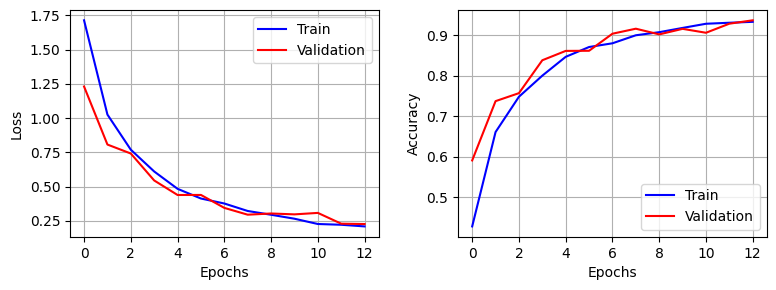

In [ ]:
# Create a figure with two subplots (side by side)
plt.figure(figsize=(8, 3))
# Plot Loss Curve (Train + Validation)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(history["epoch"], history["train_loss"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_loss"], label="Validation", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
# Plot Accuracy Curve (Train + Validation)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(history["epoch"], history["train_acc"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_acc"], label="Validation", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [ ]:
import torchmetrics

# Make sure num_classes is set correctly
num_classes = len(train_data.classes)

# Prepare metrics
test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
test_confusion_matrix = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)
test_precision = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average="macro").to(device)
test_recall = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average="macro").to(device)
test_f1_score = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

# Evaluation loop
model = model1.to(device)
model.eval()

with torch.no_grad():
    for X, Y in tqdm(test_dataloader):
        X = X.to(device)
        Y = Y.to(device)

        if Y.ndim > 1:
            Y = torch.argmax(Y, dim=1)

        preds = model(X)
        preds_class = preds.argmax(dim=1)

        test_acc.update(preds_class, Y)
        test_confusion_matrix.update(preds_class, Y)
        test_precision.update(preds_class, Y)
        test_recall.update(preds_class, Y)
        test_f1_score.update(preds_class, Y)

# Print final metrics
print("Confusion Matrix:\n", test_confusion_matrix.compute().cpu().numpy())
print("Accuracy:", test_acc.compute().item())
print("Precision:", test_precision.compute().item())
print("Recall:", test_recall.compute().item())
print("F1 Score:", test_f1_score.compute().item())

100%|██████████| 94/94 [00:11<00:00,  7.99it/s]


Confusion Matrix:
 [[171   6   0   0  19   1   0   0   1   2   0   0   0   0   0]
 [  0 197   0   0   2   0   0   0   0   0   0   0   1   0   0]
 [  0   2 187   7   0   3   0   0   0   0   0   0   0   0   1]
 [  1   0   0 185   0   7   0   0   2   2   0   0   3   0   0]
 [  0   2   0   0 195   1   0   0   1   0   0   0   1   0   0]
 [  0   4   0   0   5 182   0   0   1   0   0   0   8   0   0]
 [  0   0   1   1   0   0 185   0   1   1   1   0   8   1   1]
 [  0   0   0   0   0   0   0 199   0   0   0   0   0   0   1]
 [  0   4   0   0   6   3   0   0 175   0   0   0  12   0   0]
 [  9  14   0   0   0   3   0   0   0 172   0   0   1   0   1]
 [  4   0   0  11   0   8   0   0   2   0 175   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 200   0   0   0]
 [  0   0   0   0   2   0   0   0   0   0   0   0 198   0   0]
 [  0   0   0   0   0   0   0   0   3   0   0   0   8 189   0]
 [  1   0   0   2   1   1   0   0   0   0   0   0   5   0 190]]
Accuracy: 0.9333333373069763
Precis

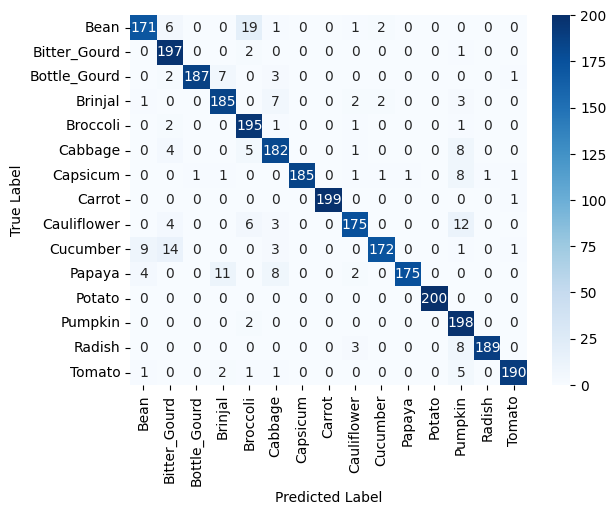

In [ ]:
# Create a heatmap for better confusion matrix visualization
sns.heatmap(test_confusion_matrix.compute().cpu(), annot=True, fmt="d",
            cmap="Blues", xticklabels=classes, yticklabels=classes)
# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Model2

In [ ]:
# Load Pretrained AlexNet
class AlexNet(nn.Module): # A class named 'AlexNet' is defined, inheriting from 'nn.Module'.
    def __init__(self, num_classes=15, dropout_p=0.5): # The constructor of the 'AlexNet' class is defined.
        super(AlexNet, self).__init__() # The parent class 'nn.Module' is initialized.

        # Define the convolutional layers
        self.cnn_layers = nn.Sequential( # A sequential container 'cnn_layers' is created to hold convolutional layers.
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2), # A 2D convolutional layer is added to 'cnn_layers'.
            nn.ReLU(inplace=True), # A ReLU activation function is added to 'cnn_layers'.
            nn.MaxPool2d(kernel_size=3, stride=2), # A max-pooling layer is added to 'cnn_layers'.
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2), # Another 2D convolutional layer is added to 'cnn_layers'.
            nn.ReLU(inplace=True), # A ReLU activation function is added to 'cnn_layers'.
            nn.MaxPool2d(kernel_size=3, stride=2), # A max-pooling layer is added to 'cnn_layers'.
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1), # A 2D convolutional layer is added to 'cnn_layers'.
            nn.ReLU(inplace=True), # A ReLU activation function is added to 'cnn_layers'.
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1), # A 2D convolutional layer is added to 'cnn_layers'.
            nn.ReLU(inplace=True), # A ReLU activation function is added to 'cnn_layers'.
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), # A 2D convolutional layer is added to 'cnn_layers'.
            nn.ReLU(inplace=True), # A ReLU activation function is added to 'cnn_layers'.
            nn.MaxPool2d(kernel_size=3, stride=2) # A max-pooling layer is added to 'cnn_layers'.
        )

        # Define the fully connected layers
        self.fc_layers = nn.Sequential( # A sequential container 'fc_layers' is created to hold fully connected layers.
            nn.Dropout(p=dropout_p), # A dropout layer is added to 'fc_layers'.
            nn.Linear(256 * 6 * 6, 4096), # A linear layer is added to 'fc_layers'.
            nn.ReLU(inplace=True), # A ReLU activation function is added to 'fc_layers'.
            nn.Dropout(p=dropout_p), # A dropout layer is added to 'fc_layers'.
            nn.Linear(4096, 4096), # A linear layer is added to 'fc_layers'.
            nn.ReLU(inplace=True), # A ReLU activation function is added to 'fc_layers'.
            nn.Linear(4096, num_classes) # A linear layer is added to 'fc_layers'.
        )

    def forward(self, x): # The 'forward' method is defined to specify the forward pass.
        # Forward pass through the network
        x = self.cnn_layers(x) # The input 'x' is passed through the convolutional layers.
        x = x.view(x.size(0), -1)  # The output is flattened.
        x = self.fc_layers(x) # The flattened output is passed through the fully connected layers.
        return x # The final output is returned.

In [ ]:
# Assuming 'device' is defined earlier in your code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize a model instance of AlexNet
model2 = AlexNet()

# Move the model to the specified device
model2 = model2.to(device)

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0003)

## Experiment

Training for one epoch:

In [ ]:
# Train one epoch
def train_one_epoch(model, dataloader, criterion, optimizer, device, num_classes):
    """
    Trains the model for one epoch.

    Args:
        model: The model to train.
        dataloader: The data loader providing training data.
        criterion: The loss function.
        optimizer: The optimizer to use for training.
        device: The device to use for training (e.g., 'cuda' or 'cpu').
        num_classes: The number of classes in the dataset.

    Returns:
        A tuple containing the average loss and accuracy for the epoch."""

    model.train()  # Set the model to training mode (enables gradients, dropout, etc.)
    losses = torchmetrics.MeanMetric().to(device)  # Create a MeanMetric object to track losses on the specified device
    acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)  # Create an Accuracy object for multi-class classification on the specified device

    for X, Y in tqdm(dataloader):  # Iterate through the data loader with a progress bar (tqdm)
        X = X.to(device)  # Move the input data (X) to the specified device
        Y = Y.to(device)  # Move the target labels (Y) to the specified device

        # Ensure Y is class indices (not one-hot encoded)
        if Y.ndim > 1:  # If Y has more than one dimension (e.g., one-hot encoded)
            Y = torch.argmax(Y, dim=1)  # Convert to class indices by taking the index of the maximum value along dimension 1
        preds = model(X)  # Pass the input data through the model to get predictions
        loss = criterion(preds, Y)  # Calculate the loss using the specified criterion
        preds_class = preds.argmax(dim=1)  # Get the predicted class indices by taking the index of the maximum value along dimension 1
        optimizer.zero_grad()  # Reset the gradients of the optimizer
        loss.backward()  # Calculate gradients through backpropagation
        optimizer.step()  # Update model parameters using the optimizer

        losses.update(loss.item(), X.size(0))  # Update the loss metric with the current batch loss and batch size
        acc.update(preds_class, Y)  # Update the accuracy metric with the predicted classes and true labels

    return losses.compute().item(), acc.compute().item()  # Return the average loss and accuracy for the epoch

Validation function for one epoch:

In [ ]:
# Validate one epoch
def validation_one_epoch(model, dataloader, criterion, device, num_classes):
    # The model is set to evaluation mode.
    model.eval()
    # A MeanMetric object is initialized and moved to the specified device for loss tracking.
    losses = torchmetrics.MeanMetric().to(device)
    # An Accuracy object is initialized and moved to the specified device for accuracy tracking.
    acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)

    # Gradient calculation is disabled within this block.
    with torch.no_grad():
        # The validation data is iterated over using the dataloader.
        for X, Y in tqdm(dataloader):
            # The input data and true labels are moved to the specified device.
            X = X.to(device)
            Y = Y.to(device)

            # If labels are one-hot encoded, they are converted to class indices.
            if Y.ndim > 1:
                Y = torch.argmax(Y, dim=1)

            # Predictions are obtained by passing the input data through the model.
            preds = model(X)
            # The loss is calculated using the specified criterion.
            loss = criterion(preds, Y)

            # Predicted class indices are extracted from the predictions.
            preds_class = preds.argmax(dim=1)

            # The losses metric is updated with the current batch loss and batch size.
            losses.update(loss.item(), X.size(0))
            # The accuracy metric is updated with the predicted classes and true labels.
            acc.update(preds_class, Y)

    # The average loss and accuracy for the epoch are returned.
    return losses.compute().item(), acc.compute().item()

Run multiple training and validation epochs:

In [ ]:
# import touchmetrics
import torchmetrics # The 'torchmetrics' library is imported.

# Training Loop
history = pd.DataFrame() # An empty pandas DataFrame called 'history' is initialized.

# Define the number of epochs for this experiment
epochs = 20 # or choose a different number

for epoch in range(epochs): # The code enters a loop that iterates over a range defined by the 'epochs' variable.
    print(f"Epoch {epoch+1}/{epochs}") # The current epoch number is printed to the console.

    # Pass optimizer and num_classes as arguments
    train_loss, train_acc = train_one_epoch(model2, train_dataloader, criterion, optimizer, device, num_classes) # The model is trained for one epoch and training loss and accuracy are obtained.
    val_loss, val_acc = validation_one_epoch(model2, val_dataloader, criterion, device, num_classes) # The model is validated for one epoch and validation loss and accuracy are obtained.

    stats = pd.DataFrame({ # A temporary pandas DataFrame called 'stats' is created.
        'epoch': [epoch+1], # The current epoch number is stored.
        'train_loss': [train_loss], # The training loss for the epoch is stored.
        'train_acc': [train_acc], # The training accuracy for the epoch is stored.
        'val_loss': [val_loss], # The validation loss for the epoch is stored.
        'val_acc': [val_acc] # The validation accuracy for the epoch is stored.
    })

    history = pd.concat([history, stats], ignore_index=True)  # The 'stats' DataFrame is appended to the 'history' DataFrame.
    print(stats.to_dict(orient="records")[0]) # The epoch statistics are printed to the console.

Epoch 1/20


100%|██████████| 94/94 [00:18<00:00,  5.04it/s]


{'epoch': 1, 'train_loss': 0.50618577003479, 'train_acc': 0.8325833082199097, 'val_loss': 0.5535278916358948, 'val_acc': 0.8193333148956299}
Epoch 2/20


100%|██████████| 94/94 [00:16<00:00,  5.55it/s]


{'epoch': 2, 'train_loss': 0.4812481701374054, 'train_acc': 0.8389166593551636, 'val_loss': 0.4259619414806366, 'val_acc': 0.8536666631698608}
Epoch 3/20


100%|██████████| 94/94 [00:16<00:00,  5.56it/s]


{'epoch': 3, 'train_loss': 0.47637394070625305, 'train_acc': 0.843833327293396, 'val_loss': 0.40448421239852905, 'val_acc': 0.8669999837875366}
Epoch 4/20


100%|██████████| 94/94 [00:17<00:00,  5.31it/s]


{'epoch': 4, 'train_loss': 0.43646037578582764, 'train_acc': 0.8569166660308838, 'val_loss': 0.40741705894470215, 'val_acc': 0.8606666922569275}
Epoch 5/20


100%|██████████| 94/94 [00:16<00:00,  5.60it/s]


{'epoch': 5, 'train_loss': 0.4158307611942291, 'train_acc': 0.8617500066757202, 'val_loss': 0.4101905822753906, 'val_acc': 0.8579999804496765}
Epoch 6/20


100%|██████████| 94/94 [00:16<00:00,  5.60it/s]


{'epoch': 6, 'train_loss': 0.404884934425354, 'train_acc': 0.8669166564941406, 'val_loss': 0.3663102090358734, 'val_acc': 0.8759999871253967}
Epoch 7/20


100%|██████████| 94/94 [00:17<00:00,  5.53it/s]


{'epoch': 7, 'train_loss': 0.41007673740386963, 'train_acc': 0.8650833368301392, 'val_loss': 0.3510546088218689, 'val_acc': 0.8793333172798157}
Epoch 8/20


100%|██████████| 94/94 [00:17<00:00,  5.29it/s]


{'epoch': 8, 'train_loss': 0.3930126428604126, 'train_acc': 0.8682500123977661, 'val_loss': 0.36225035786628723, 'val_acc': 0.8796666860580444}
Epoch 9/20


100%|██████████| 94/94 [00:16<00:00,  5.58it/s]


{'epoch': 9, 'train_loss': 0.3634842038154602, 'train_acc': 0.8827499747276306, 'val_loss': 0.3371390104293823, 'val_acc': 0.8923333287239075}
Epoch 10/20


100%|██████████| 94/94 [00:17<00:00,  5.27it/s]


{'epoch': 10, 'train_loss': 0.36856114864349365, 'train_acc': 0.8777499794960022, 'val_loss': 0.35576698184013367, 'val_acc': 0.8866666555404663}
Epoch 11/20


100%|██████████| 94/94 [00:17<00:00,  5.33it/s]


{'epoch': 11, 'train_loss': 0.3490749001502991, 'train_acc': 0.8854166865348816, 'val_loss': 0.3128964602947235, 'val_acc': 0.8923333287239075}
Epoch 12/20


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


{'epoch': 12, 'train_loss': 0.349636971950531, 'train_acc': 0.8855000138282776, 'val_loss': 0.3294113278388977, 'val_acc': 0.8963333368301392}
Epoch 13/20


100%|██████████| 94/94 [00:17<00:00,  5.36it/s]


{'epoch': 13, 'train_loss': 0.3403027653694153, 'train_acc': 0.8863333463668823, 'val_loss': 0.3369743227958679, 'val_acc': 0.887333333492279}
Epoch 14/20


100%|██████████| 94/94 [00:16<00:00,  5.58it/s]


{'epoch': 14, 'train_loss': 0.3235669434070587, 'train_acc': 0.8900833129882812, 'val_loss': 0.3387354016304016, 'val_acc': 0.8926666378974915}
Epoch 15/20


100%|██████████| 94/94 [00:17<00:00,  5.37it/s]


{'epoch': 15, 'train_loss': 0.30785906314849854, 'train_acc': 0.8988333344459534, 'val_loss': 0.26667627692222595, 'val_acc': 0.9153333306312561}
Epoch 16/20


100%|██████████| 94/94 [00:17<00:00,  5.49it/s]


{'epoch': 16, 'train_loss': 0.30927789211273193, 'train_acc': 0.9003333449363708, 'val_loss': 0.34467774629592896, 'val_acc': 0.890333354473114}
Epoch 17/20


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


{'epoch': 17, 'train_loss': 0.31319937109947205, 'train_acc': 0.8984166383743286, 'val_loss': 0.3343561589717865, 'val_acc': 0.8996666669845581}
Epoch 18/20


100%|██████████| 94/94 [00:16<00:00,  5.65it/s]


{'epoch': 18, 'train_loss': 0.2998254597187042, 'train_acc': 0.9002500176429749, 'val_loss': 0.25497719645500183, 'val_acc': 0.9166666865348816}
Epoch 19/20


100%|██████████| 94/94 [00:18<00:00,  5.19it/s]


{'epoch': 19, 'train_loss': 0.2945476472377777, 'train_acc': 0.9056666493415833, 'val_loss': 0.3037005066871643, 'val_acc': 0.9056666493415833}
Epoch 20/20


100%|██████████| 94/94 [00:17<00:00,  5.41it/s]

{'epoch': 20, 'train_loss': 0.28766655921936035, 'train_acc': 0.9072499871253967, 'val_loss': 0.311621755361557, 'val_acc': 0.9006666541099548}


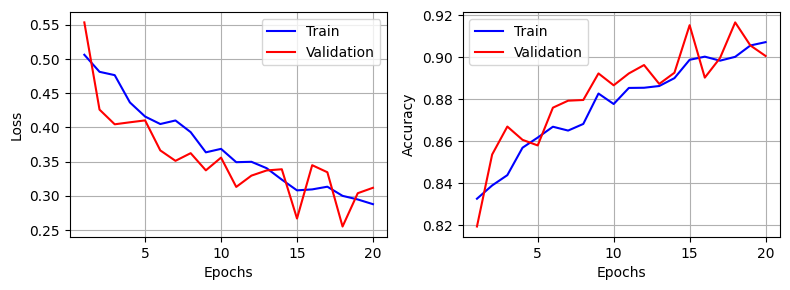

In [ ]:
# Create a figure with two subplots (side by side)
plt.figure(figsize=(8, 3))
# Plot Loss Curve (Train + Validation)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(history["epoch"], history["train_loss"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_loss"], label="Validation", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
# Plot Accuracy Curve (Train + Validation)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(history["epoch"], history["train_acc"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_acc"], label="Validation", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [ ]:
# prepare for storing evaluation metrics
test_acc = Accuracy(task='multiclass', num_classes=num_classes).to(device)
test_confusion_matrix=ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)
test_precision = Precision(task="multiclass", num_classes=num_classes, average="macro").to(device)
test_recall = Recall(task="multiclass", num_classes=num_classes, average="macro").to(device)
test_f1_score = F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

model2 = model2.to(device)
model2.eval() # set model to evaluation mode
with torch.no_grad():
  for X, Y in test_dataloader:
    X = X.to(device)
    Y = Y.to(device)
    preds = model2(X) # model forward
    preds = preds.argmax(dim=1) # obtain the final predicted class
    # store loss and accuracy per batc
    test_confusion_matrix.update(preds, Y)
    test_acc.update(preds, Y)
    test_precision.update(preds, Y)
    test_recall.update(preds, Y)
    test_f1_score.update(preds, Y)
  # Print the results
  print("Confusion Matrix:\n", test_confusion_matrix.compute())
  print("Accuracy:", test_acc.compute().item())
  print("Precision:", test_precision.compute().item())
  print("Recall:", test_recall.compute().item())
  print("F1 Score:", test_f1_score.compute().item())

Confusion Matrix:
 tensor([[182,   9,   0,   0,   0,   0,   0,   0,   0,   9,   0,   0,   0,   0,
           0],
        [  3, 193,   0,   0,   1,   0,   0,   0,   0,   2,   0,   0,   0,   0,
           1],
        [  1,   0, 192,   1,   0,   0,   0,   0,   0,   5,   0,   0,   0,   0,
           1],
        [  3,   0,   0, 185,   0,   0,   0,   0,   0,  10,   1,   0,   1,   0,
           0],
        [  5,   7,   0,   0, 183,   1,   0,   0,   0,   0,   0,   0,   3,   0,
           1],
        [  0,   3,   0,   0,   1, 191,   0,   0,   3,   0,   0,   0,   2,   0,
           0],
        [  0,   0,   0,   0,   0,   0, 197,   0,   0,   0,   0,   0,   0,   0,
           3],
        [  0,   0,   0,   0,   0,   0,   0, 198,   0,   0,   0,   0,   0,   0,
           2],
        [  0,   0,   0,   0,   0,   0,   0,   0, 199,   0,   0,   0,   1,   0,
           0],
        [  3,   1,   0,   1,   1,   0,   0,   0,   0, 193,   1,   0,   0,   0,
           0],
        [  1,   0,   2,   4,   0,   1,   

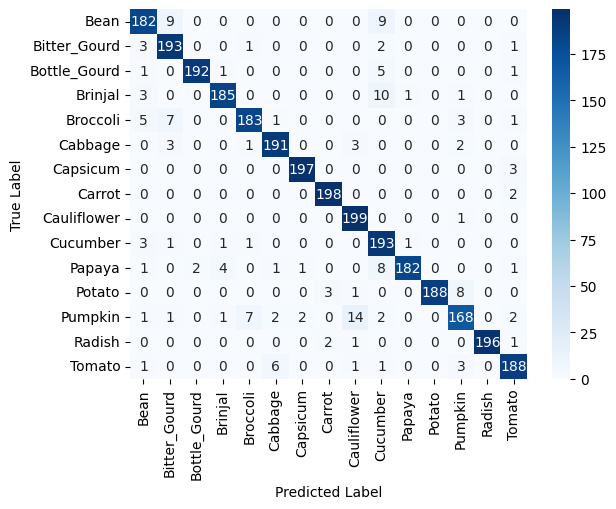

In [ ]:
# Create a heatmap for better confusion matrix visualization
sns.heatmap(test_confusion_matrix.compute().cpu(), annot=True, fmt="d",
            cmap="Blues", xticklabels=classes, yticklabels=classes)
# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Model 3

In [ ]:
# get a pretrain resnet18
model3 = torchvision.models.resnet18(weights='IMAGENET1K_V1')

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Add a new layer/change the last layer
model3.fc = nn.Linear(model3.fc.in_features, num_classes)

In [ ]:
print(model3)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Move model to GPU
model3 = model3.to(device)

loss and optimization

In [ ]:
# Specify loss function (categorical cross-entropy)
criteria = torch.nn.CrossEntropyLoss()

In [ ]:
# Specify optimizer (SGD) and learning rate = 0.001
optimizer = torch.optim.SGD(model3.parameters(), lr=0.001)

# Experiment

Training for one epoch:

In [ ]:
# a function for training one epoch
def train_one_epoch(model, dataloader):
  # Prepare for storing loss and accuracy
  losses = MeanMetric().to(device)
  acc = Accuracy(task='multiclass', num_classes=15).to(device)
  model3.train() # set model to train mode
  # a loop to iterate input(X) and label(Y) for all mini-batches
  for X, Y in tqdm(dataloader):
    X = X.to(device)
    Y = Y.to(device)
    optimizer.zero_grad() # reset optimizer
    preds = model(X) # model forward
    loss = criteria(preds, Y) # calculate loss
    loss.backward() # compute gradients via backpropagation
    optimizer.step() # perform gradient descent
    preds = preds.argmax(dim=1) # obtain the final predicted class
    losses.update(loss, X.size(0)) # store loss per batch
    acc.update(preds, Y) # store accuracy per batch
  return losses.compute().item(), acc.compute().item()

Validation function for one epoch:

In [ ]:
# a function for validation one epoch
def validation_one_epoch(model, dataloader):
  # Prepare for storing loss and accuracy
  losses = MeanMetric().to(device)
  acc = Accuracy(task='multiclass', num_classes=15).to(device)
  model3.eval() # set model to validation mode
  with torch.no_grad(): # disables gradient computation for evaluation
    # a loop to iterate input(X) and label(Y) for all mini-batches
    for X, Y in tqdm(dataloader):
      X = X.to(device)
      Y = Y.to(device)
      preds = model(X) # model forward
      loss = criteria(preds, Y) # calculate loss
      preds = preds.argmax(dim=1) # obtain the final predicted class
      losses.update(loss, X.size(0)) # store loss per batch
      acc.update(preds, Y) # store accuracy per batch
  return losses.compute().item(), acc.compute().item()

Run multiple training and validation epochs:

In [ ]:
# Prepare for storing loss and accuracy
history = pd.DataFrame() # store statics for each epoch
epochs = 10 # number of epochs
# a loop for epochs
for i in range(0, epochs):
  # train one epoch
  train_loss, train_acc = train_one_epoch(model, train_dataloader)
  # validation one epoch
  val_loss, val_acc = validation_one_epoch(model, val_dataloader)
  # store and print loss and accuracy per epoch
  statistics = pd.DataFrame({
      "epoch": [i],   "train_loss": [train_loss],
                      "train_acc": [train_acc],
                      "val_loss": [val_loss],
                      "val_acc": [val_acc]})
  history = pd.concat([history, statistics], ignore_index=True)
  print(statistics.to_dict(orient="records")[0])

100%|██████████| 94/94 [00:18<00:00,  5.08it/s]


{'epoch': 0, 'train_loss': 1.6229097843170166, 'train_acc': 0.6732500195503235, 'val_loss': 0.748927652835846, 'val_acc': 0.9286666512489319}


100%|██████████| 94/94 [00:19<00:00,  4.86it/s]


{'epoch': 1, 'train_loss': 0.5615664720535278, 'train_acc': 0.9382500052452087, 'val_loss': 0.32331913709640503, 'val_acc': 0.9599999785423279}


100%|██████████| 94/94 [00:19<00:00,  4.83it/s]


{'epoch': 2, 'train_loss': 0.31067484617233276, 'train_acc': 0.9630833268165588, 'val_loss': 0.1909235268831253, 'val_acc': 0.9779999852180481}


100%|██████████| 94/94 [00:18<00:00,  5.02it/s]


{'epoch': 3, 'train_loss': 0.2122238725423813, 'train_acc': 0.9722499847412109, 'val_loss': 0.13276220858097076, 'val_acc': 0.9816666841506958}


100%|██████████| 94/94 [00:19<00:00,  4.85it/s]


{'epoch': 4, 'train_loss': 0.16276134550571442, 'train_acc': 0.9774166941642761, 'val_loss': 0.10932226479053497, 'val_acc': 0.9789999723434448}


100%|██████████| 94/94 [00:18<00:00,  4.96it/s]


{'epoch': 5, 'train_loss': 0.13229307532310486, 'train_acc': 0.9817500114440918, 'val_loss': 0.08020564168691635, 'val_acc': 0.9886666536331177}


100%|██████████| 94/94 [00:19<00:00,  4.88it/s]


{'epoch': 6, 'train_loss': 0.1119275912642479, 'train_acc': 0.9835000038146973, 'val_loss': 0.06734410673379898, 'val_acc': 0.9886666536331177}


100%|██████████| 94/94 [00:19<00:00,  4.80it/s]


{'epoch': 7, 'train_loss': 0.09887708723545074, 'train_acc': 0.9854166507720947, 'val_loss': 0.0587642565369606, 'val_acc': 0.9896666407585144}


100%|██████████| 94/94 [00:19<00:00,  4.75it/s]


{'epoch': 8, 'train_loss': 0.08451581001281738, 'train_acc': 0.9871666431427002, 'val_loss': 0.051202259957790375, 'val_acc': 0.9933333396911621}


100%|██████████| 94/94 [00:19<00:00,  4.78it/s]

{'epoch': 9, 'train_loss': 0.07908490300178528, 'train_acc': 0.9884166717529297, 'val_loss': 0.0430494025349617, 'val_acc': 0.9953333139419556}


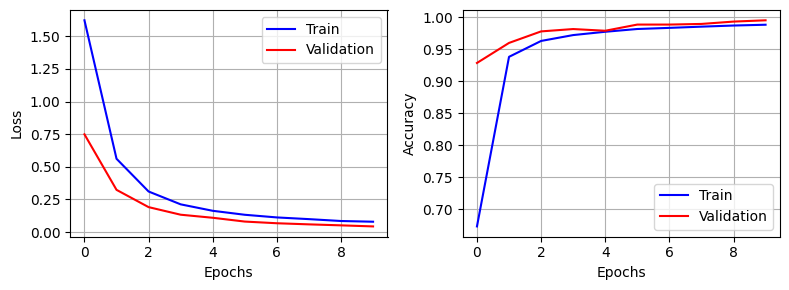

In [ ]:
# Create a figure with two subplots (side by side)
plt.figure(figsize=(8, 3))
# Plot Loss Curve (Train + Validation)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(history["epoch"], history["train_loss"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_loss"], label="Validation", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
# Plot Accuracy Curve (Train + Validation)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(history["epoch"], history["train_acc"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_acc"], label="Validation", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Final test

In [ ]:
# prepare for storing evaluation metrics
test_acc = Accuracy(task='multiclass', num_classes=num_classes).to(device)
test_confusion_matrix=ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)
test_precision = Precision(task="multiclass", num_classes=num_classes, average="macro").to(device)
test_recall = Recall(task="multiclass", num_classes=num_classes, average="macro").to(device)
test_f1_score = F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

model = model.to(device)
model.eval() # set model to evaluation mode
with torch.no_grad():
  for X, Y in test_dataloader:
    X = X.to(device)
    Y = Y.to(device)
    preds = model(X) # model forward
    preds = preds.argmax(dim=1) # obtain the final predicted class
    # store loss and accuracy per batc
    test_confusion_matrix.update(preds, Y)
    test_acc.update(preds, Y)
    test_precision.update(preds, Y)
    test_recall.update(preds, Y)
    test_f1_score.update(preds, Y)
  # Print the results
  print("Confusion Matrix:\n", test_confusion_matrix.compute())
  print("Accuracy:", test_acc.compute().item())
  print("Precision:", test_precision.compute().item())
  print("Recall:", test_recall.compute().item())
  print("F1 Score:", test_f1_score.compute().item())

Confusion Matrix:
 tensor([[200,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0, 200,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  2,   0, 198,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0, 200,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0, 200,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0, 200,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   0, 200,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   0,   0, 200,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 200,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   2,   0,   0,   0,   0,   0, 198,   0,   0,   0,   0,
           0],
        [  0,   0,   1,   3,   0,   0,   

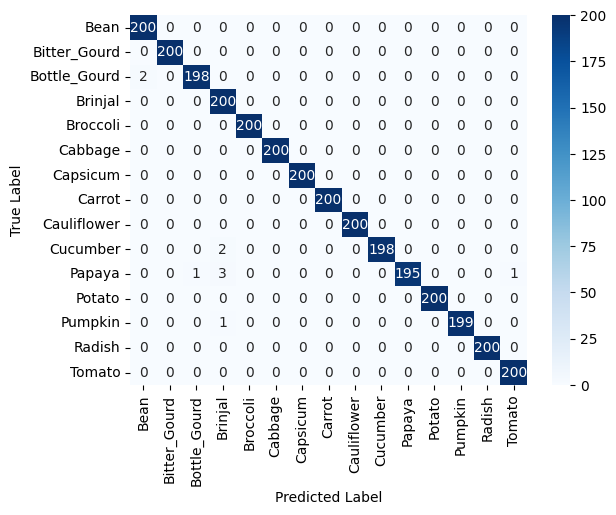

In [ ]:
# Create a heatmap for better confusion matrix visualization
sns.heatmap(test_confusion_matrix.compute().cpu(), annot=True, fmt="d",
            cmap="Blues", xticklabels=classes, yticklabels=classes)
# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Your model results (replace with your actual values)
data = {
    'Model': ['ResNet18', 'AlexNet', 'CustomCNN'],
    'Accuracy': [0.99, 0.89, 0.83],
    'Precision': [0.99, 0.88, 0.87],
    'Recall': [0.99, 0.87, 0.86],
    'F1-Score': [0.99, 0.875, 0.865]
}

df = pd.DataFrame(data)

# Plot Grouped Bar Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(df['Model']))  # Model positions
width = 0.2  # Width of each bar

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each metric side-by-side
for i, metric in enumerate(metrics):
    ax.bar(x + i * width, df[metric], width, label=metric)

# Labels & Title
ax.set_ylabel('Score')
ax.set_xlabel('Model')
ax.set_title('Model Performance Comparison (ResNet18, AlexNet, CustomCNN)')
ax.set_xticks(x + width * (len(metrics)-1) / 2)
ax.set_xticklabels(df['Model'])
ax.legend()

plt.ylim(0, 1)  # Ensure graph is from 0 to 1
plt.show()